# Compare GM outputs from notebook and odc-stats

In [1]:
from odc.stats.plugins.gm import StatsGMS2
from odc.stats.tasks import TaskReader
from odc.stats.model import OutputProduct

In [2]:
# find tile locations using .geojson output from odc-stats save-tasks
# define x, y index and year, which has to be aligned with what's used in odc-stats save-tasks

x, y = 235, -15
year = "2024--P1Y"
#cloud_filters= {"cloud shadows", "cloud medium probability", "cloud high probability", "thin cirrus":[["opening", 5], ["dilation", 5]]}
cloud_filters= {"cloud shadows":[["dilation", 5]], "cloud medium probability":[["opening", 5], ["dilation", 5]], "cloud high probability":[["opening", 5], ["dilation", 5]], "thin cirrus":[["dilation", 5]]}


## Accessing task database

In [3]:
# Dummy product to pass to taskreader

name, version = 'gm_s2', '0-0-1' # product name and version (appended to results path)
product = OutputProduct(name=name,
                        version=version,
                        short_name=name,
                        location = "",
                        properties = {},
                        measurements = [],
#                        location = "file:///home/jovyan/dev/gm/",
#                        properties ={"odc:file_format": "GeoTIFF"},
#                        measurements =["blue", "red", "green", "nir"],
                       )



tidx = (year, x, y)
rdr = TaskReader("s2_l2a_2024--P1Y.db", product=product)
task = rdr.load_task(tidx)
task


Task(product=OutputProduct(name='gm_s2', version='0-0-1', short_name='gm_s2', location='', properties={}, measurements=[], href='https://collections.dea.ga.gov.au/product/gm_s2', region_code_format='x{x:02d}y{y:02d}', cfg=None, naming_conventions_values='dea_c3', explorer_path='https://explorer.dea.ga.gov.au/', inherit_skip_properties=None, preview_image_ows_style=None, classifier='level3', maturity='final', collection_number=3, nodata=None), tile_index=(235, -15), geobox=GeoBox((5000, 5000), Affine(10.0, 0.0, 11750000.0,
       0.0, -10.0, -700000.0), CRS('ESRI:54034')), time_range=DateTimeRange(datetime.datetime(2024, 1, 1, 0, 0), '1Y'), uuid=UUID('b008930f-4c9b-54c6-a085-59fcfa0c06ea'))

## Option - use notebook method

In [4]:
import datacube

# Connect to ODC
dc = datacube.Datacube(app="geomad_s2")

In [5]:
sentinel2_datasets = dc.find_datasets(
    product=["s2_l2a"],
    time="2024",
    like=task.geobox.to_crs("EPSG:4326"), # non-EPSG is not accepted
    cloud_cover=(0, 10),
)

Querying product Product(name='s2_l2a', id_=9)


In [6]:
# expect same number of datasets found
len(task.datasets), len(sentinel2_datasets)

(24, 24)

In [7]:
# Load available data
ds = dc.load(
    datasets=sentinel2_datasets,
    geopolygon=task.geobox.extent,  
    measurements=["red", "green", "blue", "scl"],
    dask_chunks={"x": 5000, "y": 5000, "time":-1},
    resolution=(-10,10),
    group_by="solar_day",
    output_crs=task.geobox.crs, #"ESRI:54034"
    driver="rio",
)

In [8]:
# expect same number of days for this tile in s2_l2a_2024--P1Y.csv
ds

<xarray.Dataset> Size: 3GB
Dimensions:      (y: 5000, x: 5000, time: 15)
Coordinates:
  * y            (y) float64 40kB -7e+05 -7e+05 -7e+05 ... -7.5e+05 -7.5e+05
  * x            (x) float64 40kB 1.175e+07 1.175e+07 ... 1.18e+07 1.18e+07
    spatial_ref  int32 4B 0
  * time         (time) datetime64[ns] 120B 2024-05-06T03:29:56.644000 ... 20...
Data variables:
    red          (time, y, x) uint16 750MB dask.array<chunksize=(15, 5000, 5000), meta=np.ndarray>
    green        (time, y, x) uint16 750MB dask.array<chunksize=(15, 5000, 5000), meta=np.ndarray>
    blue         (time, y, x) uint16 750MB dask.array<chunksize=(15, 5000, 5000), meta=np.ndarray>
    scl          (time, y, x) uint8 375MB dask.array<chunksize=(15, 5000, 5000), meta=np.ndarray>

In [9]:
ds["scl"].attrs['flags_definition'] =dc.list_measurements().loc['s2_l2a','scl']['flags_definition']
ds["scl"].attrs['flags_definition']

{'qa': {'bits': [0, 1, 2, 3, 4, 5, 6, 7],
  'values': {'0': 'no data',
   '1': 'saturated or defective',
   '2': 'dark area pixels',
   '3': 'cloud shadows',
   '4': 'vegetation',
   '5': 'bare soils',
   '6': 'water',
   '7': 'unclassified',
   '8': 'cloud medium probability',
   '9': 'cloud high probability',
   '10': 'thin cirrus',
   '11': 'snow or ice'},
  'description': 'Sen2Cor Scene Classification'}}

In [10]:
from odc.algo import enum_to_bool, erase_bad
from odc.algo import mask_cleanup

# Apply the same cloud filter
# Erase Data Pixels for which mask == nodata
mask = ds["scl"]
bad = enum_to_bool(mask, ("no data",))
for cloud_class, c_filter in cloud_filters.items():
    if not isinstance(cloud_class, tuple):
        cloud_class = (cloud_class,)
        cloud_mask = enum_to_bool(mask, cloud_class)
        cloud_mask_buffered = mask_cleanup(cloud_mask, mask_filters=c_filter)
        bad = cloud_mask_buffered | bad

ds = ds.drop_vars(["scl"])
ds = erase_bad(ds, bad)

In [18]:
from odc.algo import geomedian_with_mads
gm = geomedian_with_mads(ds)

In [19]:
gm

<xarray.Dataset> Size: 500MB
Dimensions:  (y: 5000, x: 5000)
Coordinates:
  * y        (y) float64 40kB -7e+05 -7e+05 -7e+05 ... -7.5e+05 -7.5e+05
  * x        (x) float64 40kB 1.175e+07 1.175e+07 ... 1.18e+07 1.18e+07
Data variables:
    red      (y, x) uint16 50MB dask.array<chunksize=(100, 100), meta=np.ndarray>
    green    (y, x) uint16 50MB dask.array<chunksize=(100, 100), meta=np.ndarray>
    blue     (y, x) uint16 50MB dask.array<chunksize=(100, 100), meta=np.ndarray>
    smad     (y, x) float32 100MB dask.array<chunksize=(100, 100), meta=np.ndarray>
    emad     (y, x) float32 100MB dask.array<chunksize=(100, 100), meta=np.ndarray>
    bcmad    (y, x) float32 100MB dask.array<chunksize=(100, 100), meta=np.ndarray>
    count    (y, x) uint16 50MB dask.array<chunksize=(100, 100), meta=np.ndarray>
Attributes:
    nodata:   0

### Option - use GM plugin to process

In [11]:
# Use gm plugin to generate GM
# use same configuration as 
gm = StatsGMS2(resampling="nearest", 
               bands=["blue", "green", "red", "nir", "swir16", "swir22"], 
                cloud_filters=cloud_filters,
               work_chunks=(100,100),
)
xx = gm.input_data(task.datasets, task.geobox)
xx = gm.native_transform(xx)
output = gm.reduce(xx)

In [12]:
output

<xarray.Dataset> Size: 650MB
Dimensions:  (y: 5000, x: 5000)
Coordinates:
  * y        (y) float64 40kB -7e+05 -7e+05 -7e+05 ... -7.5e+05 -7.5e+05
  * x        (x) float64 40kB 1.175e+07 1.175e+07 ... 1.18e+07 1.18e+07
Data variables:
    blue     (y, x) uint16 50MB dask.array<chunksize=(5000, 5000), meta=np.ndarray>
    green    (y, x) uint16 50MB dask.array<chunksize=(5000, 5000), meta=np.ndarray>
    red      (y, x) uint16 50MB dask.array<chunksize=(5000, 5000), meta=np.ndarray>
    nir      (y, x) uint16 50MB dask.array<chunksize=(5000, 5000), meta=np.ndarray>
    swir16   (y, x) uint16 50MB dask.array<chunksize=(5000, 5000), meta=np.ndarray>
    swir22   (y, x) uint16 50MB dask.array<chunksize=(5000, 5000), meta=np.ndarray>
    SMAD     (y, x) float32 100MB dask.array<chunksize=(5000, 5000), meta=np.ndarray>
    EMAD     (y, x) float32 100MB dask.array<chunksize=(5000, 5000), meta=np.ndarray>
    BCMAD    (y, x) float32 100MB dask.array<chunksize=(5000, 5000), meta=np.ndarray>
    COUNT    (y, x) uint16 50MB dask.array<chunksize=(5000, 5000), meta=np.ndarray>
Attributes:
    units:       1
    nodata:      0
    _FillValue:  0

In [13]:
#compute
#output = output.compute()

### Load odc-stats run output

In [14]:
import xarray as xr

#Assume output save in current location
basepath = f"x{x:03d}/y{y:03d}/{year}/gm_s2_x{x:03d}y{y:03d}_{year}"

bands = ['red', 'green', 'blue']
datasets = [xr.open_dataset(f'{basepath}_{band}.tif',chunks ={}).squeeze() for band in bands]
datasets = [ds.rename_vars({list(ds.data_vars)[0]: name}) for ds, name in zip(datasets, bands)]

combined = xr.merge(datasets)
combined

<xarray.Dataset> Size: 300MB
Dimensions:      (x: 5000, y: 5000)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 40kB 1.175e+07 1.175e+07 ... 1.18e+07 1.18e+07
  * y            (y) float64 40kB -7e+05 -7e+05 -7e+05 ... -7.5e+05 -7.5e+05
    spatial_ref  int64 8B 0
Data variables:
    red          (y, x) float32 100MB dask.array<chunksize=(800, 800), meta=np.ndarray>
    green        (y, x) float32 100MB dask.array<chunksize=(800, 800), meta=np.ndarray>
    blue         (y, x) float32 100MB dask.array<chunksize=(800, 800), meta=np.ndarray>

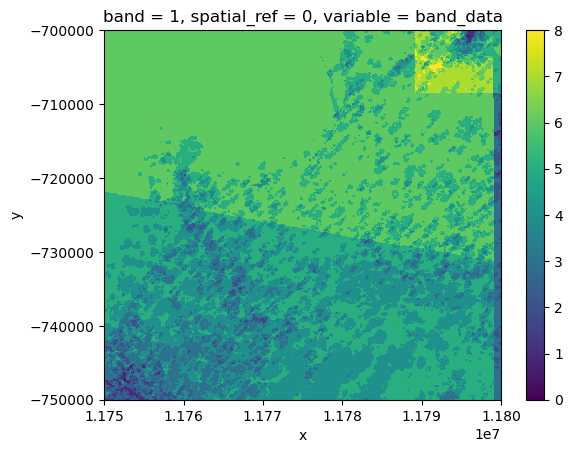

In [15]:
count = xr.open_dataset(f'{basepath}_COUNT.tif').squeeze().to_array().squeeze()
count.plot.imshow()

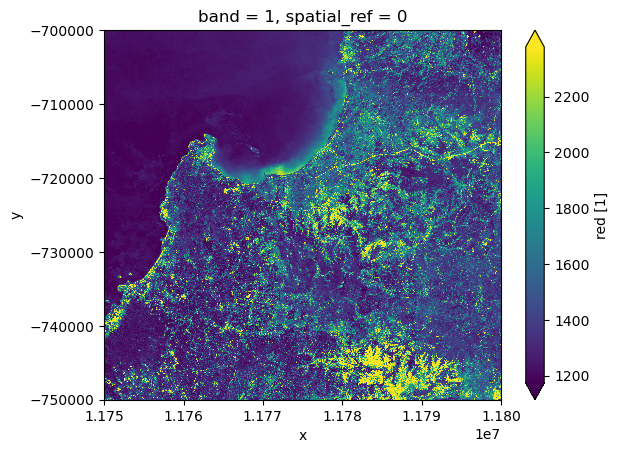

In [16]:
combined.red.plot.imshow(robust=True)